### 套件預處理

In [3]:
# !pip install wandb

In [ ]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbCallback, WandbModelCheckpoint, WandbEvalCallback

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv as kcv

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from keras.models import Sequential
from keras.applications import VGG16
from keras import Model
from keras.utils import to_categorical, image_dataset_from_directory
from keras.applications import EfficientNetB0, ResNet50V2, ConvNeXtBase
from keras.callbacks import Callback
from keras.losses import CategoricalCrossentropy
from keras.optimizers import RMSprop, AdamW

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

In [6]:
rand_augment = kcv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    geometric=True,
    rate=0.7,
    )

cut_mix = kcv.layers.CutMix()
mix_up = kcv.layers.MixUp()

le = LabelEncoder()
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'

In [8]:
train_datagen = ImageDataGenerator(
    )

df = pd.read_csv("./nptu-dl-final-project/train.csv")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory="./nptu-dl-final-project/train",
    x_col='img_file',
    y_col='label',
    target_size= (224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()} 
# class_indices


Found 15198 validated image filenames belonging to 109 classes.


### 偵測系統中的 GPU 個數

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 超參數

In [14]:
configs = dict(
    train_dir = './nptu-dl-final-project/train',
    train_csv = './nptu-dl-final-project/train.csv',
    num_classes = 109,
    batch_size = 32,
    image_size = (224, 224),
    earlystopping_patience = 3,
    warmup_learning_rate = 1e-3,
    initial_learning_rate = 5e-4,
    epochs = 95,
    test_dir = '/kaggle/input/112-nptu-dl-final-project/test',
    
    model_name = 'dark', #dark, efficientnet
    advanced_aug = 'cutmix_mixup', # none, cutmix, mixup, or cutmix_mixup 
    seed = 42, # the random seed
)
# 儲存 label名稱，和 label id 的對照表 (之後要建立 submission 檔用的)
LABEL_TBL = 'label_table.csv'
AUTO = tf.data.AUTOTUNE

# Reproducibility：指定種子，讓實驗可以重現
keras.utils.set_random_seed(configs['seed'])

### 資料處理

In [11]:
def update_img_name(row, path):
    """
    本函式會把每張圖片加上路徑
    """
    return f'{path}/{row.img_file}'

In [12]:
# check whether dffiles.img_file exists in folder configs['train_dir']
def check_image_exist(row):
    return os.path.exists(row.img_file)

Label Encoder :

使用 laber encoder 將 comment 編碼成數字

In [17]:
le = LabelEncoder()
dffiles = pd.read_csv(configs['train_csv'])
dffiles['label'] = le.fit_transform(dffiles.label)
dffiles.head()

,img_file,label
0,78fbc980fba54a0e98da22352d44e51d.jpg,24
1,6c761e579cc542ebbaa9a932c9b22b08.jpg,27
2,f475146a31564c929e09f0724af3723b.jpg,78
3,bfa1d3e9b6684d43ab81eb836670d942.jpg,39
4,c42ce1c6a0944b0c86a48950f87bc2fe.jpg,74


In [18]:
dffiles.label.value_counts(normalize=True)

label
5      0.032044
33     0.031517
93     0.031057
8      0.030859
34     0.030201
         ...   
101    0.003948
63     0.003882
98     0.003750
3      0.003290
84     0.002632
Name: proportion, Length: 109, dtype: float64

### 函式定義

In [19]:
preprocess_map = {
    'efficientnetb0': keras.applications.efficientnet.preprocess_input,
    'resnet50': keras.applications.resnet_v2.preprocess_input,
    'convnextbase': keras.applications.convnext.preprocess_input 
}

def get_preprocess_func(model_name):
    return preprocess_map[model_name]

In [20]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_image(file_bytes, channels=3, expand_animations = False) 
    image = tf.image.resize(image, configs['image_size'][:2], method="bilinear")
    image = tf.cast(image, tf.float32) 
    
    if label is not None:
        label = tf.one_hot(label, configs['num_classes'])
    
    #label = tf.cast(label, tf.float32)
    if label is not None:
        return {"images": image, "labels": label}
    else:
        return {"images": image}

In [21]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(10, 10)).suptitle(title, fontsize=14)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples[0]
        labels = samples[1] 
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy())
        # draw the one-hot label on the top of image
        label = ','.join([str(f'{i:.2f}') for i in labels[0].numpy()])

        plt.title(f'[{label}]', fontsize=10)
        plt.axis("off")
    plt.show()


### 資料擴增

In [22]:
def apply_base_augmentation(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

def apply_cutmix_augmentation(inputs):
    inputs = cut_mix(inputs, training=True)
    return inputs

def apply_mixup_augmentation(inputs):
    inputs = mix_up(inputs, training=True)
    return inputs

def apply_cutmix_mixup_augmentation(inputs):
    inputs = cut_mix(inputs, training=True)
    inputs = mix_up(inputs, training=True)  
    return inputs

測試 cutmix, mixup, cutmix_mixup 資料擴增的結果

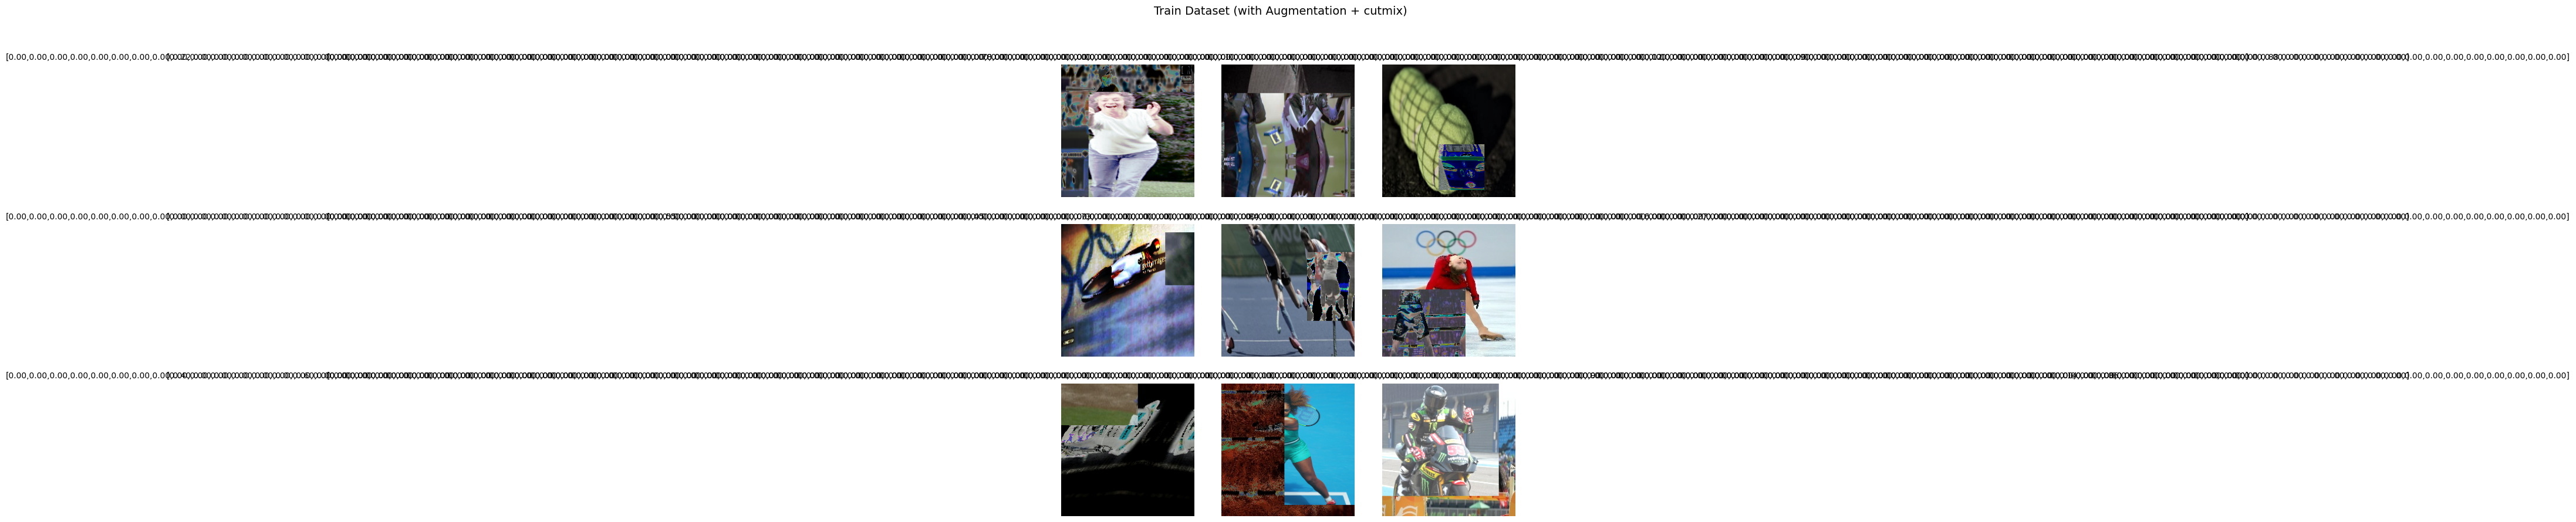

In [29]:
# Data visualization
dftrain, dfval = get_train_val_dataframes(configs['train_csv'])

train_ds = build_train_ds(dftrain)
val_ds = build_train_ds(dfval)

# 保留前 advanced_aug 的值
old_aug = configs['advanced_aug']
configs['advanced_aug'] = 'cutmix'
dftrain, dfval = get_train_val_dataframes(configs['train_csv'])

train_ds = build_train_ds(dftrain)
val_ds = build_train_ds(dfval)

visualize_dataset(train_ds, 'Train Dataset (with Augmentation + cutmix)')
#回存
configs['advanced_aug'] = old_aug

### 讀取資料

In [23]:
def get_train_val_dataframes(filename, test_size=0.2):
    dffiles = pd.read_csv(filename)
    dffiles.img_file = dffiles.apply(update_img_name, args=(configs['train_dir'],), axis=1)
    dffiles['label'] = le.fit_transform(dffiles.label)
    x=dffiles.img_file
    y=dffiles.label
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=test_size,random_state=0,stratify=y)
    dftrain = pd.concat((x_train,y_train), axis=1)
    dfval = pd.concat((x_val,y_val), axis=1)

    return dftrain, dfval

def get_test_dataframe(filename):
    dffiles = pd.read_csv(filename)
    dffiles.img_file = dffiles.apply(update_img_name, args=(configs['test_dir'],), axis=1)
    dffiles['label'] = le.transform(dffiles.label)
    # use dffiles.img_file and dffiles.label to construct a dataframe dftest
    dftest = dffiles[['img_file', 'label']]
    return dftest


def get_oversampling_train_val_dataframes(filename, test_size=0.2):

    dffiles = pd.read_csv(filename)
    dffiles.img_file = dffiles.apply(update_img_name, args=(configs['train_dir'],), axis=1)
    dffiles['label'] = le.fit_transform(dffiles.label)
    x=dffiles.img_file
    y=dffiles.label
    class_counts = Counter(y)
    max_samples = max(class_counts.values())
    sampling_strategy = {cls: max_samples for cls in class_counts}
    # 使用上採樣，讓所有的 label 都有一樣多的樣本
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

    x, y = ros.fit_resample(x.values.reshape(-1,1),y.values.reshape(-1,1))
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=test_size,random_state=0,stratify=y)
    x_train = x_train.reshape(-1)
    x_val = x_val.reshape(-1)
    y_train = y_train.reshape(-1)
    y_val = y_val.reshape(-1)
    
    dftrain = pd.DataFrame({'img_file':x_train, 'label':y_train})
    dfval = pd.DataFrame({'img_file':x_val, 'label':y_val})
    return dftrain, dfval

In [24]:
def build_dataset(image_paths, labels, is_shuffle=True, is_aug=True):

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(decode_image_and_label, num_parallel_calls=AUTO) # map 會針對所讀入的每個路徑來做 decode_image_and_label 的動作
    if is_shuffle:
        ds = ds.shuffle(configs['batch_size'] * 10) # shuffle 會洗亂資料
    ds = ds.batch(configs['batch_size']) # batch 會打包圖片成一個 batch
    
    if is_aug:
        ds = ds.map(apply_base_augmentation, num_parallel_calls=AUTO) # 再用 map 針對每一個 batch 的圖片做資料擴增
        
        if configs['advanced_aug'] == 'cutmix':
            ds = ds.map(apply_cutmix_augmentation, num_parallel_calls=AUTO)
        elif configs['advanced_aug'] == 'mixup':
            ds = ds.map(apply_mixup_augmentation, num_parallel_calls=AUTO)
        elif configs['advanced_aug'] == 'cutmix_mixup':
            ds = ds.map(apply_cutmix_mixup_augmentation, num_parallel_calls=AUTO)
    # normalize ds['images'] to [0, 1]
    ds = ds.map(lambda x: (x['images'] / 255, x['labels']), num_parallel_calls=AUTO)
    # 把資料轉為 tuple 格式，以符合 keras 模型的需求
    #ds = ds.map(lambda x: (x['images'], x['labels']), num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)        

    return ds

In [25]:
def build_train_ds(dftrain):
    train_ds = build_dataset(dftrain.img_file, dftrain.label)
    return train_ds
def build_test_ds(dftest):
    test_ds = build_dataset(dftest.img_file, dftest.label, is_shuffle=False, is_aug=False)
    return test_ds

def load_train_val_test_ds(upsampling=False):
    if upsampling:
        dftrain, dfval = get_oversampling_train_val_dataframes(configs['train_csv'])
    else:
        dftrain, dfval = get_train_val_dataframes(configs['train_csv'])
#     dftest = get_test_dataframe(configs['test_csv'])
    train_ds = build_train_ds(dftrain)
    val_ds = build_test_ds(dfval)
#     test_ds = build_test_ds(dftest)
    return train_ds, val_ds

### 建立模型

In [ ]:
def create_backbone():
    if configs['model_name'] == 'dark': #使用darknet
        backbone = kcv.models.CSPDarkNetBackbone.from_preset("csp_darknet_l_imagenet", input_shape=configs['image_size']+(3,))
    elif configs['model_name'] == 'efficientnet':
        backbone = kcv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_s_imagenet", input_shape=configs['image_size']+(3,))
    backbone.include_rescaling = False
    return backbone

In [26]:
def create_model():
    
    IMG_SIZE = configs['image_size'] + (3,)
    inputs = Input(shape=IMG_SIZE)
    backbone = create_backbone()
    x = backbone(inputs)

    x = GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    
    outputs = Dense(configs['num_classes'], activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

Callback function:

用來記錄目前的 learning rate

In [27]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.lr

### 訓練模型 ( 方法ㄧ)

Experiment 1: baseline，使用三個模型，加上 data augmentation 的技巧，試著做運動的影像分類。這三個模型是 resent50, efficientb0, 以及 ConvNeXtBase。這個實驗中，沒有使用任何解決 imbalance 的技巧，所以應該是效能最差的一個結果。因此底下其他的實驗都可以跟這個 baseline，看效能有沒有提升。

In [ ]:
exp_prefix = 'exp1'
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
# 設定earlystop條件
estop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# 設定模型儲存條件
checkpoint = ModelCheckpoint('BestLossModel.keras', verbose=1,
                          monitor='val_loss', save_best_only=True,
                          mode='min')


# for mname in model_names:
configs['model_name'] = 'dark'
train_ds, val_ds, = load_train_val_test_ds()

total_train_steps = len(train_ds) * configs['epochs']
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

model = create_model()
cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=configs['initial_learning_rate'],
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=configs['warmup_learning_rate'],
        warmup_steps=warmup_steps,
    )

optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)

model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), 
        metrics=['accuracy', keras.metrics.CategoricalCrossentropy(label_smoothing=0.1), keras.metrics.F1Score(average='macro', dtype='float32')])


history = model.fit(train_ds, validation_data=val_ds, 
    epochs=configs['epochs'], callbacks=[checkpoint, estop])
print('Evaluating the model...')

### 訓練模型 ( 方法二 )

Experiment 2:  使用 CutMix，CutOut 的 image augmentation 技巧，讓資料得以平衡。看能不能提升效能。

### 繪製成果

In [ ]:
# Extracting training and validation metrics from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_path = "/kaggle/input/112-nptu-dl-final-project/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_filenames = [f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.jpeg'))]

df_test = pd.DataFrame({
    'img_file': test_filenames,
    'label': ['unknown'] * len(test_filenames)
})

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='img_file',
    y_col=None,  # no label
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  
    shuffle=False  # 保持文件順序
)
###-----
# 使用TTA 多跑幾次取平均最高的class
import math

def tta_predict(model, generator, steps, tta_steps=8):
    preds = []
    for _ in range(tta_steps):
        generator.reset()
        pred = model.predict(generator, steps=steps, verbose=1)
        preds.append(pred)
    return np.mean(preds, axis=0)

# 使用 math.ceil 確保所有數據都被覆蓋，以免少數據
test_steps = math.ceil(len(test_filenames) / 32)
tta_test_preds = tta_predict(model, test_generator, steps=test_steps)
predicted_classes = np.argmax(tta_test_preds, axis=1)

In [ ]:
#get jpg files name
filenames = test_generator.filenames
filenames = [f.split('/')[-1] for f in filenames]  
#對應標籤
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}

In [ ]:
predicted_labels = [class_indices[int(k)] for k in predicted_classes] #寫入csv
results = pd.DataFrame({
    'img_file': test_filenames,
    'label': predicted_labels
})
results.to_csv('/kaggle/working/submit.csv', index=False)